
## TW8 Unsupervised Learning

### Clustering

Basic use of common clustering models

- K-means

- DBSCAN

### Part 0

- Examples of the use of K-means and its comparisons with DBSCAN. 

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import seaborn as sn
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clustering_kmeans"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Utility functions

In [2]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    plt.show()

    
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

### K-means model

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.
    
    
The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

### 1. A synthetic dataset

This example creates a synthetic dataset with make_blobs, then applies k-means to find 3 clusters, and plots the points in each cluster identified by a corresponding color.

#### Generate a dataset

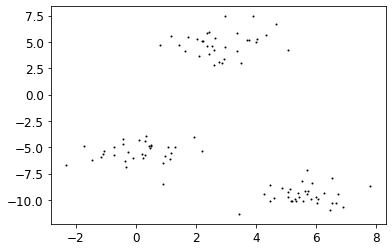

In [3]:
from sklearn.datasets import make_blobs

rand_state = 10

X, y = make_blobs(random_state = rand_state)

plot_data(X)

#### K-means model

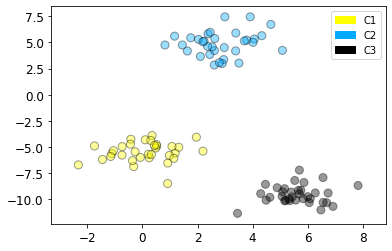

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2', 'C3'])

### 2. Real dataset: Fruit dataset

#### Load the data

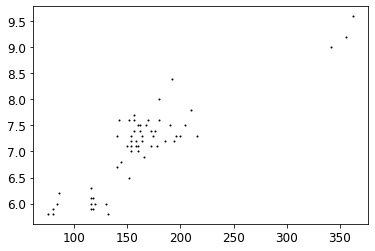

In [5]:
fruits = pd.read_csv('./data/fruit_data_with_colors.txt', sep='\t', engine='python')

X_fruits = fruits[['mass','width','height', 'color_score']].values
y_fruits = fruits[['fruit_label']] - 1


# plot the data (only use 2 attributes, 'mass', 'width')
plot_data(X_fruits)

#### Standarizing the data (scaling)

- Note that in general, it's important to scale the individual features before applying k-means clustering.

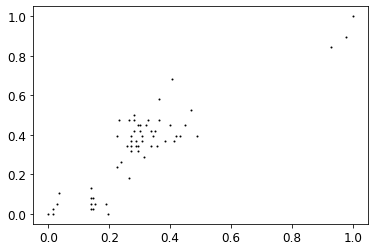

In [6]:
from sklearn.preprocessing import MinMaxScaler


from sklearn.preprocessing import MinMaxScaler

X_normalized = MinMaxScaler().fit(X_fruits).transform(X_fruits)

plot_data(X_normalized)

#### K-means model

- This example showing k-means used to find 4 clusters in the fruits dataset.

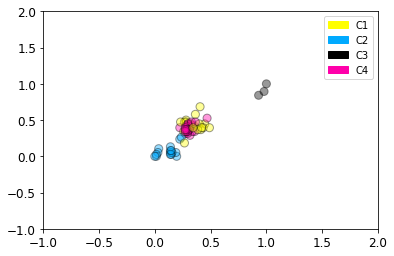

In [7]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_normalized)

plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2', 'C3', 'C4'])

### 3. k-means vs. DBSCAN clustering

### (1) A simple dataset

#### Generate a dataset

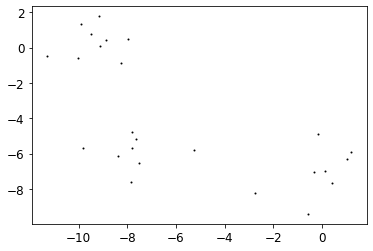

In [8]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state = 9, n_samples = 25)

plot_data(X)

#### K-means model

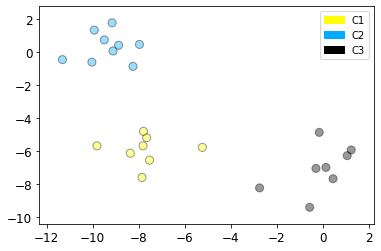

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2', 'C3'])

#### DBSCAN model

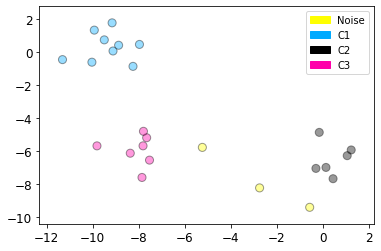

In [10]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps = 2, min_samples= 2)
cls = dbscan.fit_predict(X)

plot_labelled_scatter(X, cls + 1, ['Noise', 'C1', 'C2', 'C3'])

### (2) K-Means and DBSCAN on a more complex dataset


#### Generate a synthetic dataset

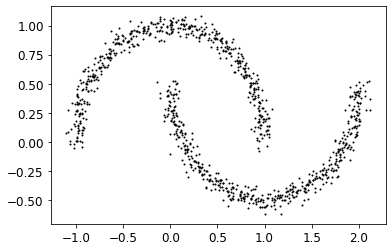

In [11]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

plot_data(X)

#### K-means model


- Apply k-means model

- use k = 2

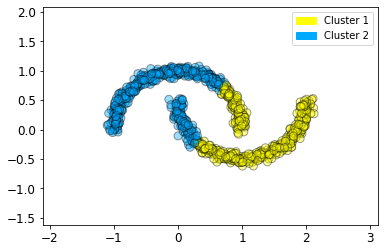

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['Cluster 1', 'Cluster 2'])

#### DBSCAN model

- Apply DBSCAN model

- use eps=0.2, min_samples=5

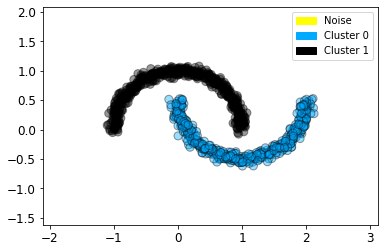

In [13]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
cls = dbscan.fit_predict(X)

plot_labelled_scatter(X, cls + 1, ['Noise', 'Cluster 0', 'Cluster 1'])

### (3) Apply k-means model on breast cancer dataset and check the model performance

#### A simple evaluation on K-means

- Apply k-means model with k = 2

- print the sum of all correctly predicted data (y_predicted==y_cancer)

- Since we have y_cancer values, we compare the predicted value to its y_cancer value. The ratio of correctly predicted class can represent the accuracy of the model. 

#### load the data

- load breast cancer dataset from sklearn.datasets (set the parameter, return_X_y = True)

- normalize the data

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler

# Breast cancer dataset
cancer = load_breast_cancer()

(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# Normalization of data
X_normalized = MinMaxScaler().fit(X_cancer).transform(X_cancer)  

#### K-Means on non-normalized data

In [15]:
from sklearn.cluster import KMeans

kmeans_no = KMeans(n_clusters = 2)
kmeans_no.fit(X_cancer)

y_predicted = kmeans_no.predict(X_cancer)

print(np.sum(y_predicted==y_cancer))

print(np.sum(y_predicted==y_cancer) / len(y_predicted))

486
0.8541300527240774


#### K-Means on normalized data

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_normalized)

y_predicted = kmeans.predict(X_normalized)

print(np.sum(y_predicted==y_cancer))

print(np.sum(y_predicted==y_cancer) / len(y_predicted))

528
0.9279437609841827


### (4) Evaluation Quality of Clusters - K-means

- We will apply two evaluation methods, Inertia and Silhouette score.

- Please read the documentation of these two methods:

    - https://scikit-learn.org/stable/modules/clustering.html

    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
    
- Find Optimal k values based on the evaluation. 


#### Inertia Measure

Sum of distances of samples to their closest cluster center

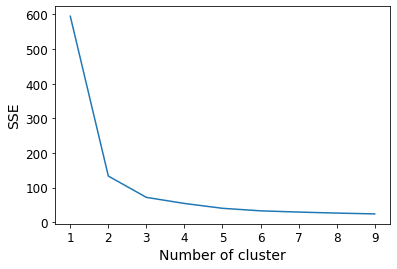

In [17]:
from sklearn.datasets import load_iris

iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris['feature_names'])
data = X[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']]

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_

    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#### Silhouette Score

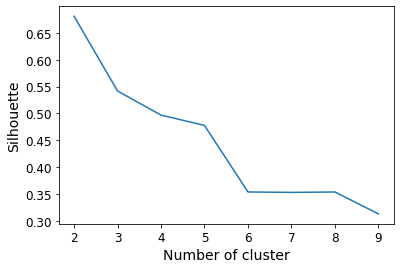

In [18]:
from sklearn.datasets import load_iris
from sklearn import metrics

iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris['feature_names'])
data = X[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']]

score = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    labels = kmeans.labels_

    score[k] = metrics.silhouette_score(X, labels, metric='euclidean')

plt.figure()
plt.plot(list(score.keys()), list(score.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette")
plt.show()

### (5) Silhouette Score Example

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.56376469026194
For n_clusters = 6 The average silhouette_score is : 0.4504666294372765


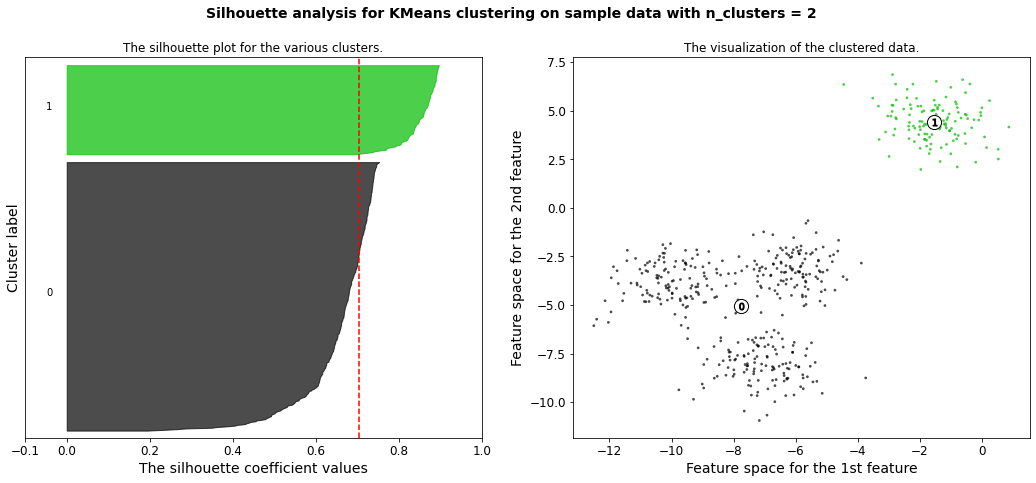

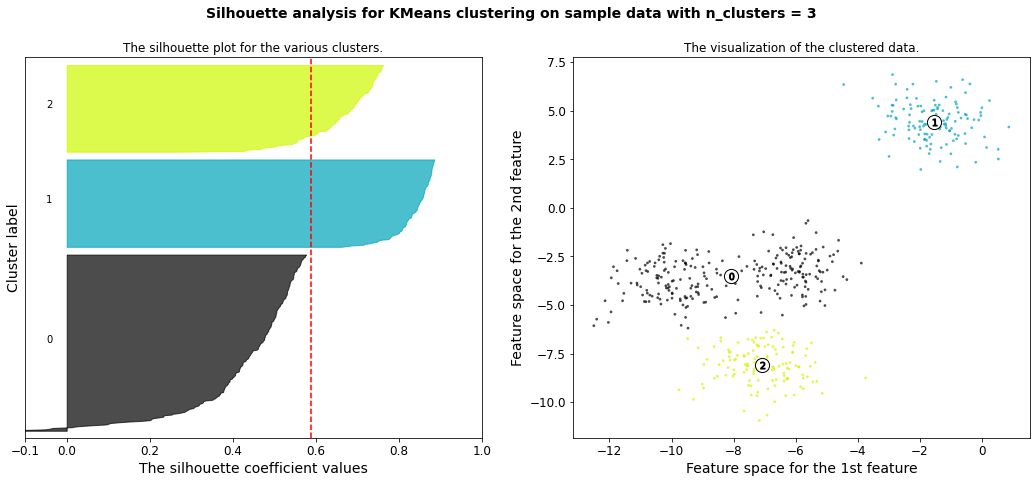

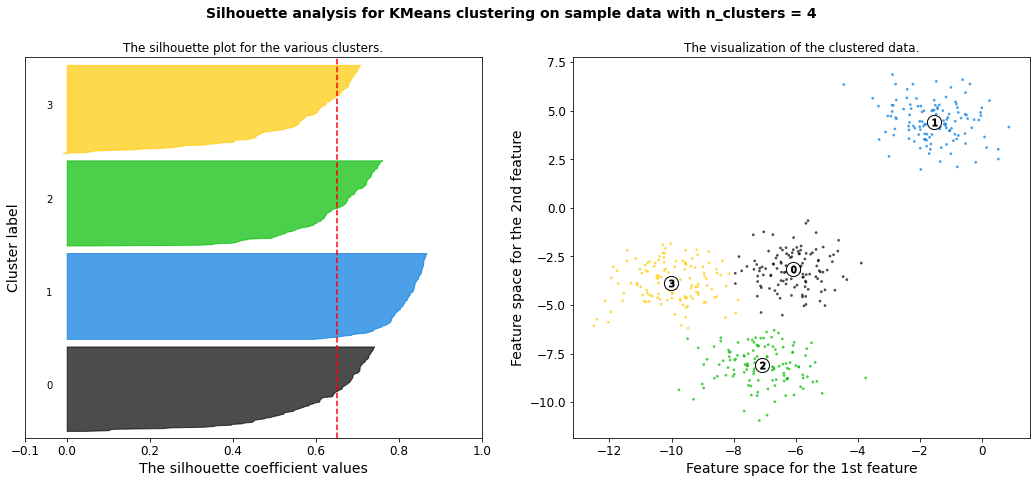

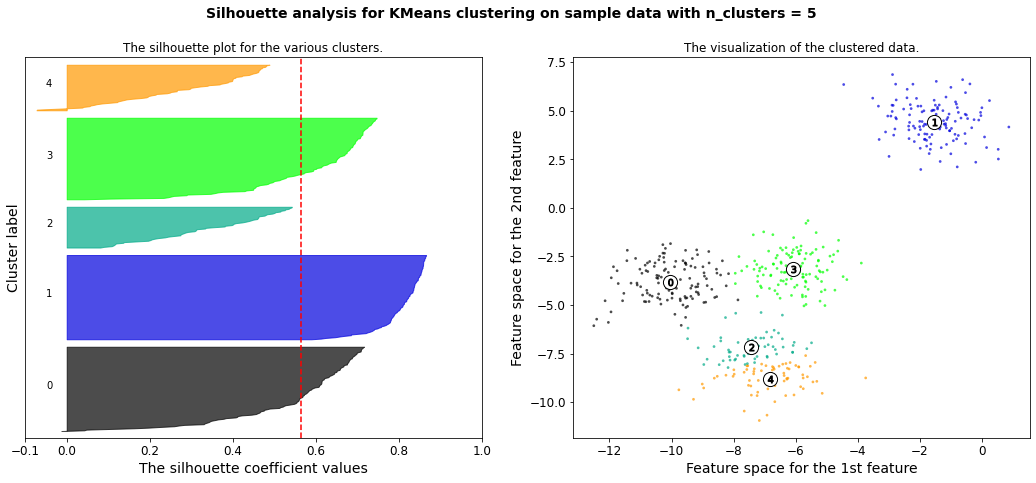

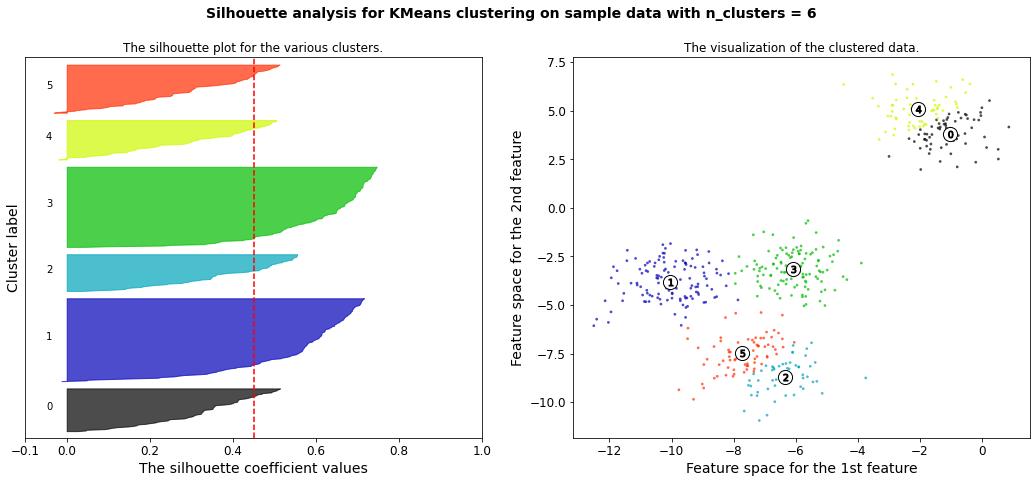

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

## Part 1

### Task: Apply K-Means on your dataset

- Find out optimal k value(s) for the dataset through clustering evaluation. 

    - Use two methods (Inertia and Silhouette score)

- Visualize the clusters

### Submissions:

- Upload the notebook (clustering_basic.ipynb) on GitHub.

- Write the names of students who worked on this assignment.

- Write the link to the notebook on Canvas.

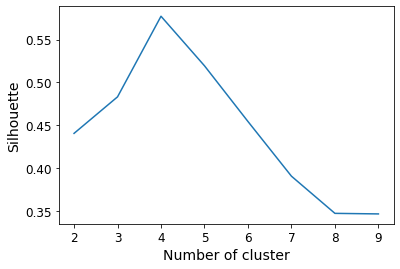

In [20]:
from sklearn.datasets import load_iris
from sklearn import metrics

X = pd.read_csv("./data/data_multivar.txt")
X.head()

data = X



# # # data = X[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']]

score = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    labels = kmeans.labels_

    score[k] = metrics.silhouette_score(X, labels, metric='euclidean')

plt.figure()
plt.plot(list(score.keys()), list(score.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette")
plt.show()

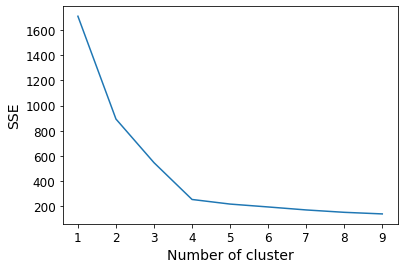

In [21]:
data = X

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_

    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.56376469026194
For n_clusters = 6 The average silhouette_score is : 0.4504666294372765


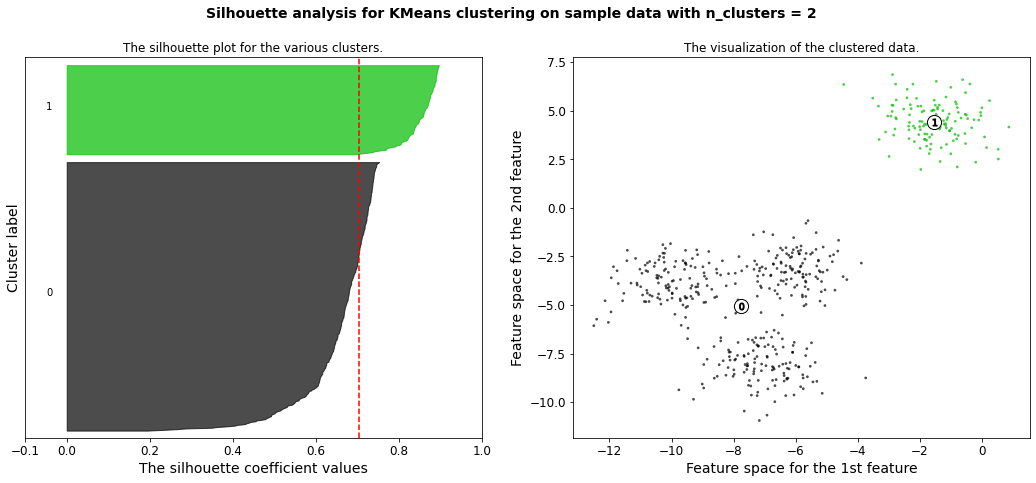

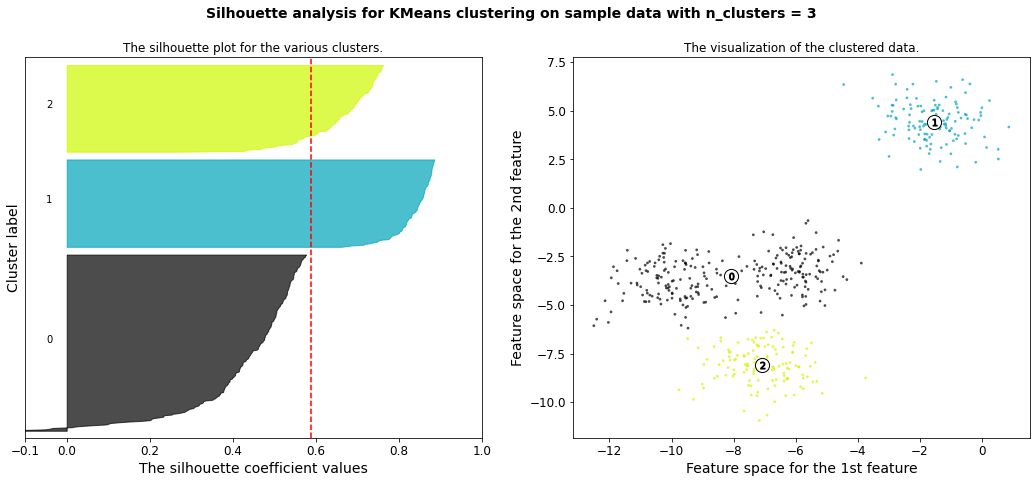

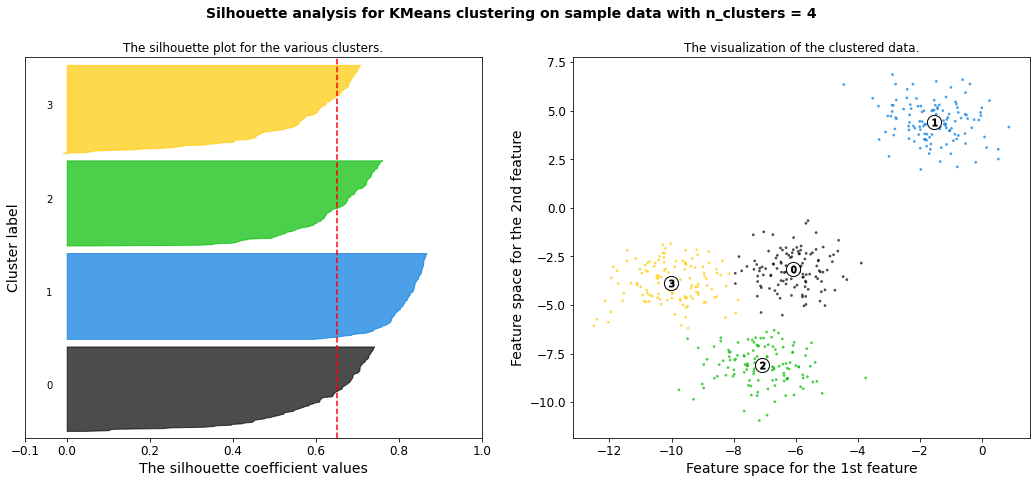

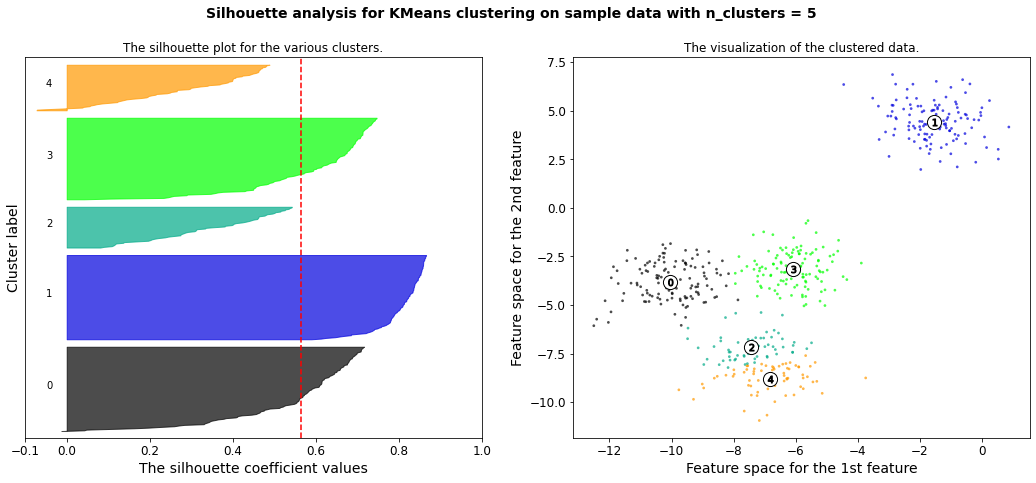

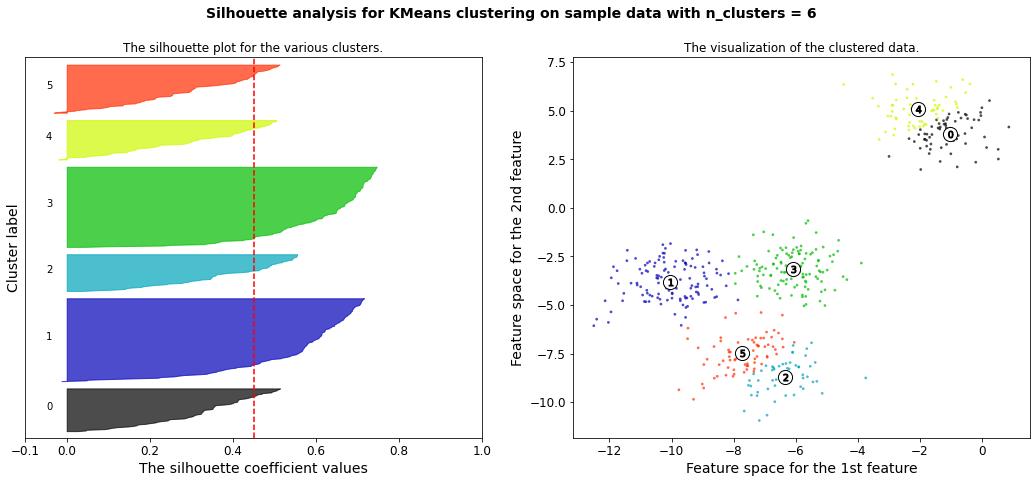

In [22]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Zachary Jeffreys, Bart Nadala, Maason Kao

Summary: 
From our analysis we have determined that the n_clusters = 4 would be the best for this data set. We determined this from first conducting a silhouette and a SSE elbow test. First off we conducted a silloute test to see the amount of clusters that had the highest silloute score. For ours we found that 4 clusters had the highest at about 0.6. We then tested the SSE elbow test. For this test, we used distance from the centroid to determine the best amount of clusters. We found that between 1-4 clusters had the steepest curves. To further proove our findings, we conducted another silloute study, but this time we wanted to compare the silhoutte plot of various clusters to see which amount of clusters had the most evenly dispirsed data. For this, we found again that 4 clusters had the best results. 
    